# Week 1 Notebook

## Imports

In [138]:
#Main Imports
import cv2
import numpy as np
import os
from distances import find_distance, distance_metrics
from histogram import calc_3d_hist, calc_1d_hist
import get_images_and_labels
import evaluation as eval
import pickle
import glob


In [139]:
#Notebook imports
import matplotlib.pyplot as plt
import random

In [140]:
cur_path = os.getcwd()

# Available color_spaces
color_spaces = {
"RGB": cv2.COLOR_BGR2RGB,
"HSV": cv2.COLOR_BGR2HSV,
"YCRCB": cv2.COLOR_BGR2YCrCb,
"LAB": cv2.COLOR_BGR2LAB
}

In [141]:
DISPLAY_ALL = False
CONVERT_RGB = False

In [142]:
if CONVERT_RGB : 
    # Get the 3 images dataset or 
    if DISPLAY_ALL:
        museum_imgs = [cv2.cvtColor(image, color_spaces["RGB"]) for image in get_images_and_labels.get_museum_dataset(cur_path)]
        query_set1_imgs = [cv2.cvtColor(image, color_spaces["RGB"]) for image in get_images_and_labels.get_query_set_images(cur_path, "qsd1")]
    query_set2_imgs = [cv2.cvtColor(image, color_spaces["RGB"]) for image in get_images_and_labels.get_query_set_images(cur_path, "qsd2")]
else:
    if DISPLAY_ALL:
        museum_imgs = get_images_and_labels.get_museum_dataset(cur_path)
        query_set1_imgs = get_images_and_labels.get_query_set_images(cur_path, "qsd1")
    query_set2_imgs = get_images_and_labels.get_query_set_images(cur_path, "qsd2")

#Get Query Set 2 Masks
query_set2_masks = [cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY).astype("bool") for mask in get_images_and_labels.get_qsd2_masks(cur_path)]

In [143]:
if DISPLAY_ALL:
    f, axs = plt.subplots(1,3, figsize=(30,10))

    axs[0].imshow(random.choice(museum_imgs))
    axs[0].title.set_text("Museum Dataset")
    axs[1].imshow(random.choice(query_set1_imgs))
    axs[1].title.set_text("Query Dataset 1 ")
    axs[2].imshow(random.choice(query_set2_imgs))
    axs[2].title.set_text("Query Dataset 2")
    for ax in axs:
        ax.axis('off') 

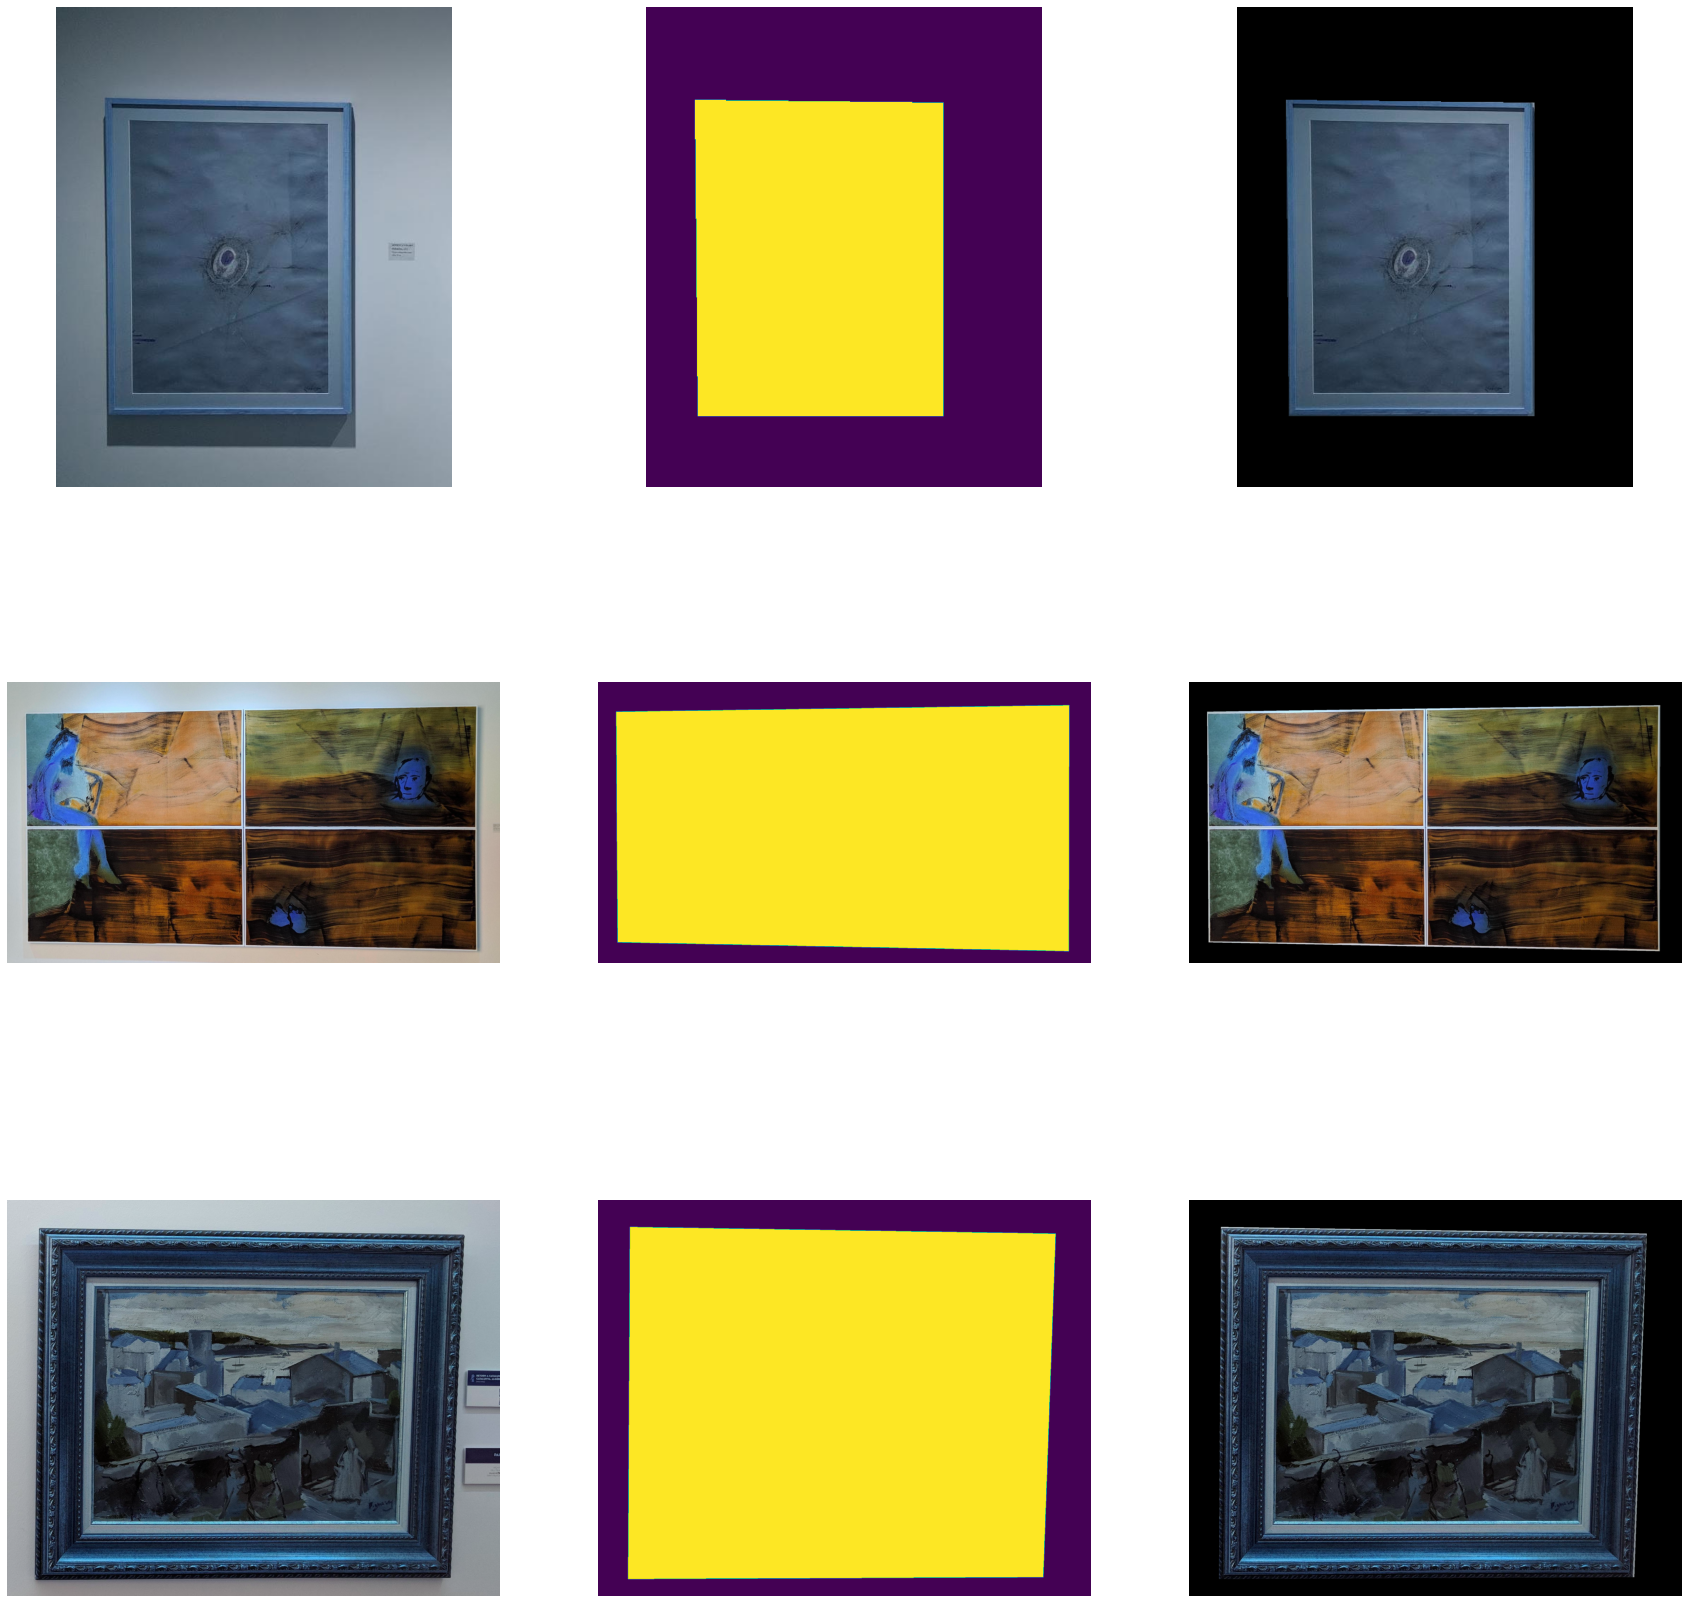

In [144]:
from itertools import product
f, axs = plt.subplots(3,3, figsize=(30,30))

for i in range(3):
    idx = random.randint(0,len(query_set2_imgs)-1)
    axs[i,0].imshow(query_set2_imgs[idx])
    axs[i,1].imshow(query_set2_masks[idx])
    axs[i,2].imshow(query_set2_imgs[idx]*query_set2_masks[idx][:,:,None], cmap="gray")

for i,j in product(range(3), range(3)):
    axs[i,j].axis('off')

In [145]:
def background_removal(image, ):
    """
    Remove background from image.
    This functions takes an image as input and return a mask of where it believes the picture is.
    Parameters
    ----------
    image : numpy array
            An array containing the image you want to remove the background.
    Returns
    -------
    mask : numpy array
            The mask corresponding to the believed position of the painting on the image.
    """

    LIMIT = 10

    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    h, w = image.shape
    mask = np.zeros_like(image) + 1

    for i in range(h):
        for j in range(w-1):
                if abs(int(image[i,j]) - int(image[i,j+1])) <= LIMIT:
                        mask[i,j] = 0
                else:
                        break
        for j in range(w-1,0,-1):
                if abs(int(image[i,j]) - int(image[i,j-1])) <= LIMIT:
                        mask[i,j] = 0
                else:
                        break
    for j in range(w):
        for i in range(h-1):
                if abs(int(image[i,j]) - int(image[i+1,j])) <= LIMIT:
                        mask[i,j] = 0
                else:
                        break
        for i in range(h-1,0,-1):
                if abs(int(image[i-1,j]) - int(image[i,j])) <= LIMIT:
                        mask[i,j] = 0
                else:
                        break

    return mask


In [146]:
def enhance_mask(mask):
    num_labels, im_labels = cv2.connectedComponents(mask)
    
    max_area, best_label = 0 , -1
    for label in range(num_labels):
        #If the background area is larger than the picture, we don't want the background
        if im_labels[0,0] == label:
            continue

        area = np.sum(im_labels == label)
        if area > max_area:
            best_label = label
            max_area = area
    
    enhanced_mask = np.array(im_labels == best_label)

    return enhanced_mask

In [147]:
def evaluate_mask(predicted_mask, true_mask):
    """
    Evaluates predicted mask precision, recall and F1-measure.
    Parameters
    ----------
    predicted_mask : numpy array
            An array containing the mask predicted by the background remover.
    true_mask : numpy array
            An array containing the true mask of the picture location.
    Returns
    -------
    precision : float
            Precision of the prediction = TP/(TP+FP)
    Recall : float
            Recall of the prediction = TP/(TP+FN)
    F1-Measure : float
            F1-Measure of the prediction = 2*(Precision . Recall)/(Precision + Recall)
    """

    #Compute the True Positives, False Positives, False Negatives
    TP = np.sum(true_mask*predicted_mask)
    FP = np.sum(predicted_mask) - TP
    FN = np.sum(true_mask) - TP

    #Compute the precision, recall, f1-score
    precision = TP / (TP+FP)
    recall = TP/ (TP+FN)
    f1_score = 2*precision*recall/(precision+recall)

    return precision, recall, f1_score

In [148]:
idx = random.randint(0,len(query_set2_imgs)-1)
image, mask = query_set2_imgs[idx], query_set2_masks[idx]
hist_1d = calc_1d_hist(image)
hist_3d = calc_3d_hist(image)

In [149]:
predicted_mask = background_removal(image)

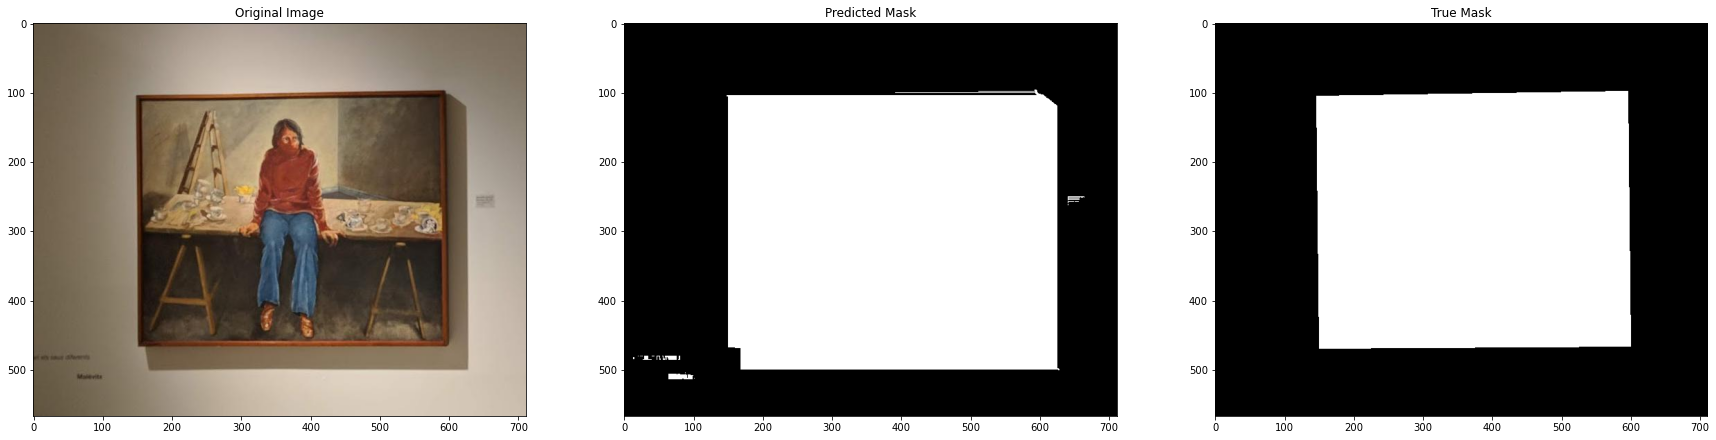

In [150]:
f, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].imshow(cv2.cvtColor(image, color_spaces["RGB"]))
axs[0].title.set_text("Original Image")
axs[1].imshow(predicted_mask, cmap="gray")
axs[1].title.set_text("Predicted Mask")
axs[2].imshow(mask, cmap="gray")
axs[2].title.set_text("True Mask")

In [158]:
enhanced_mask = enhance_mask(predicted_mask)

dtype('bool')

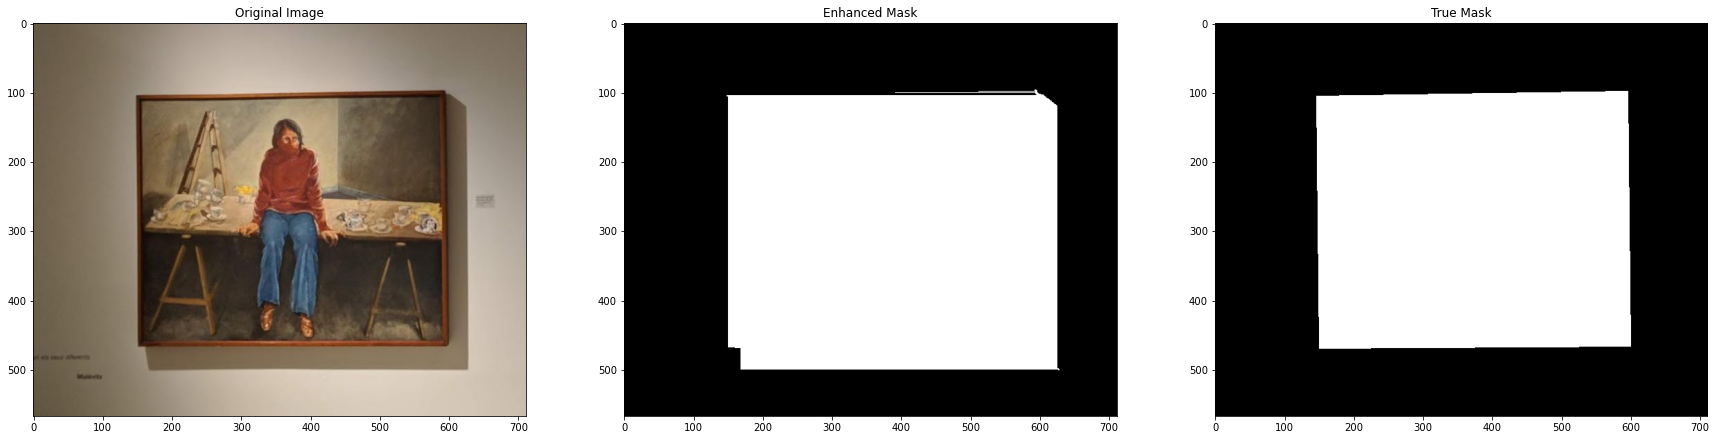

In [152]:
f, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].imshow(cv2.cvtColor(image, color_spaces["RGB"]))
axs[0].title.set_text("Original Image")
axs[1].imshow(enhanced_mask, cmap="gray")
axs[1].title.set_text("Enhanced Mask")
axs[2].imshow(mask, cmap="gray")
axs[2].title.set_text("True Mask")


In [153]:
evaluate_mask(enhanced_mask,mask)

TP : 163457 - FP : 24259 - FN : 1711


(0.8707675424577553, 0.9896408505279473, 0.9264064111719431)

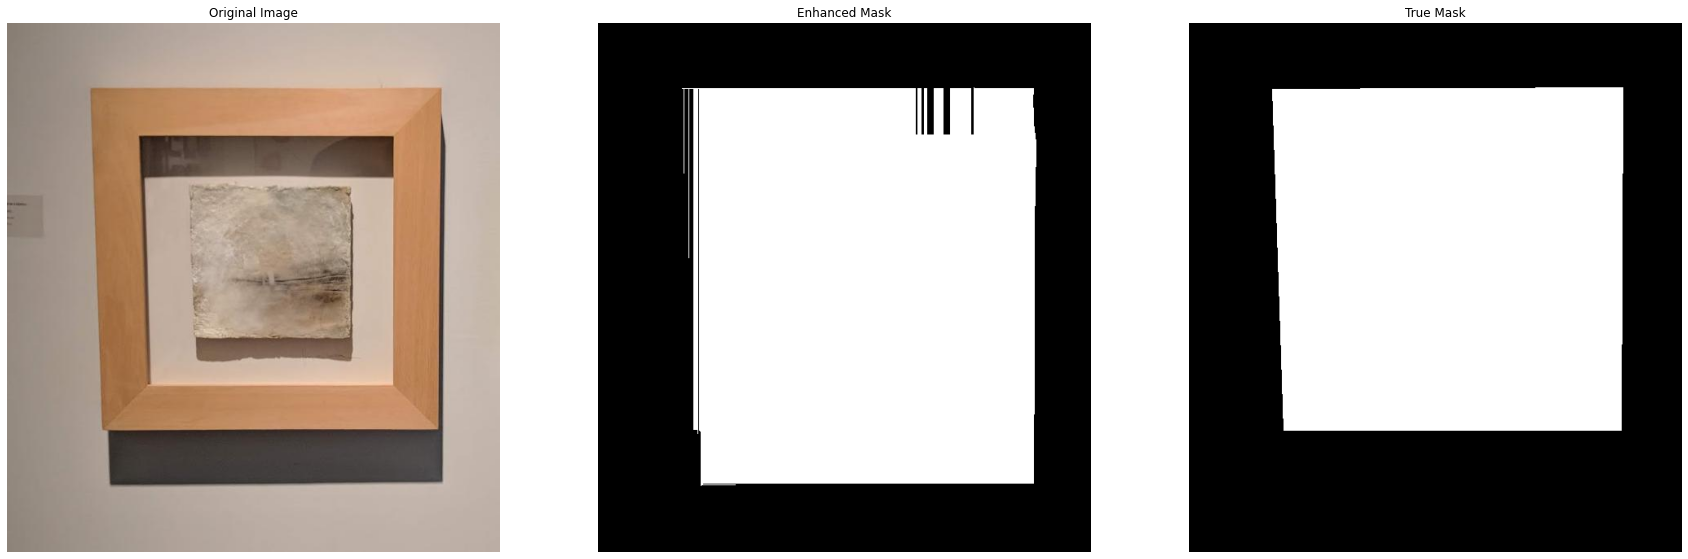

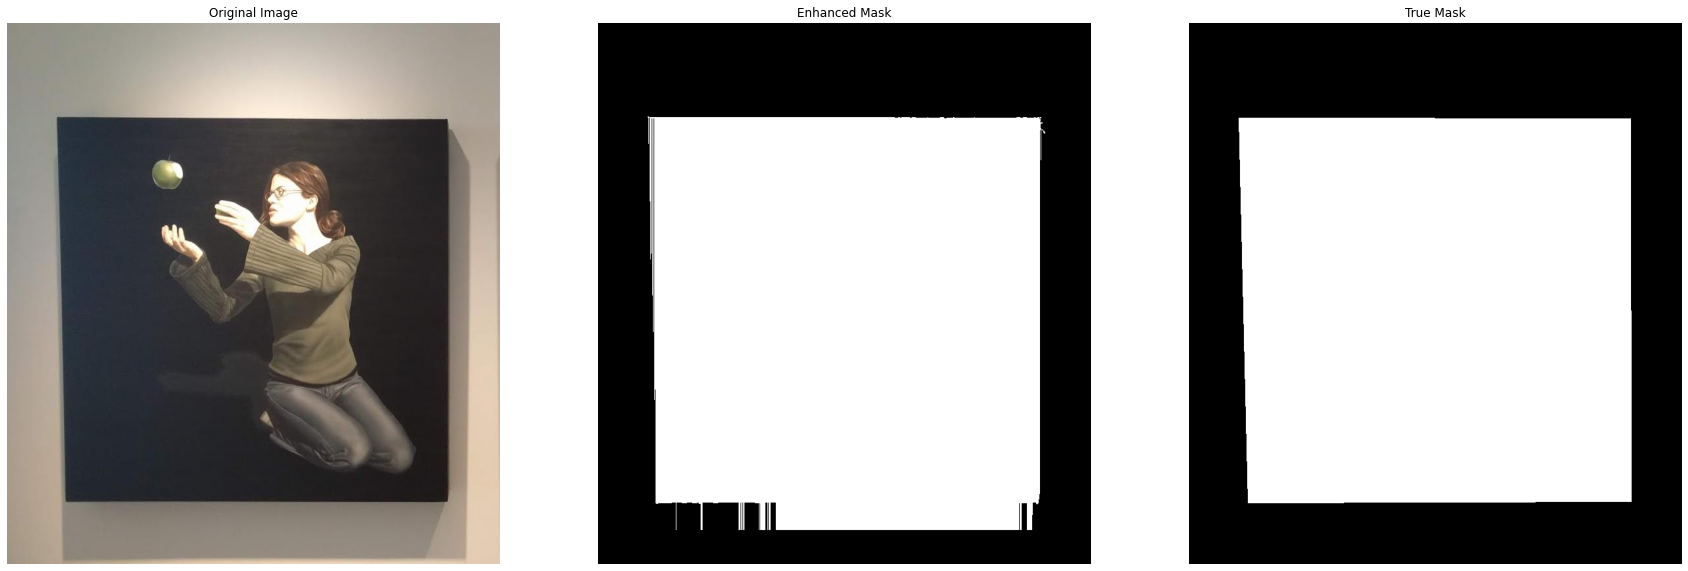

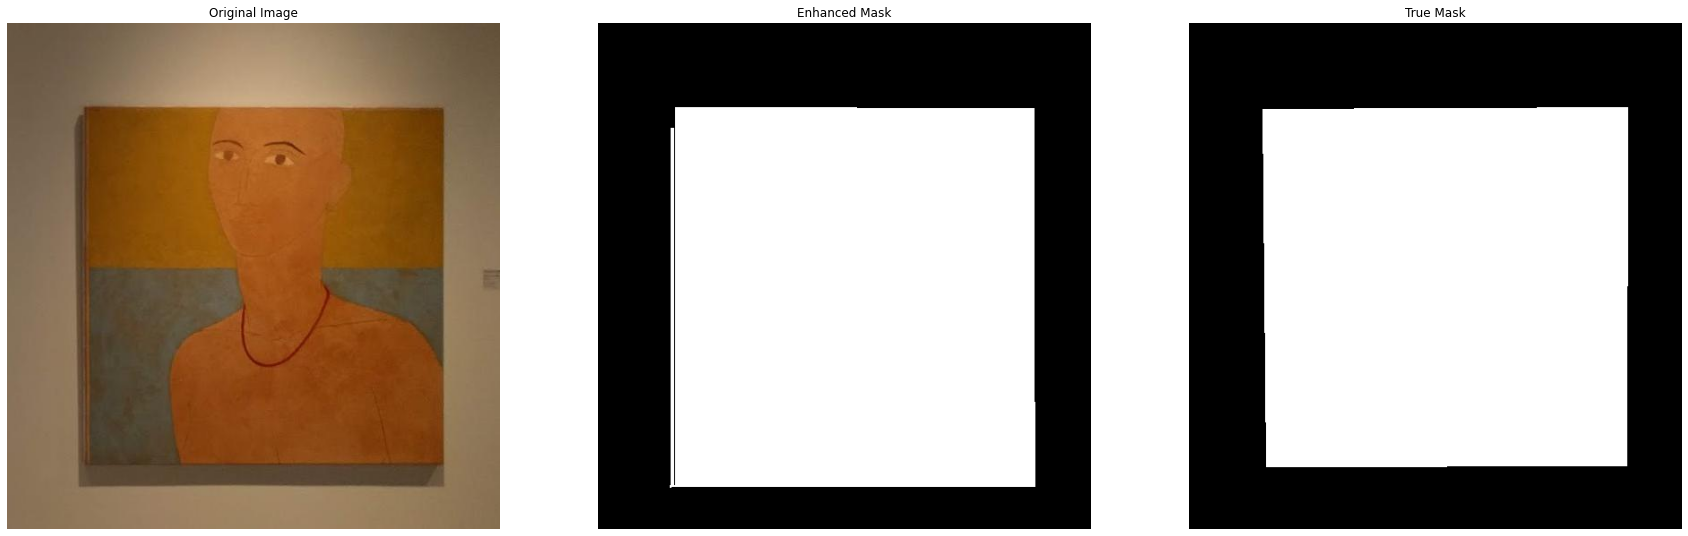

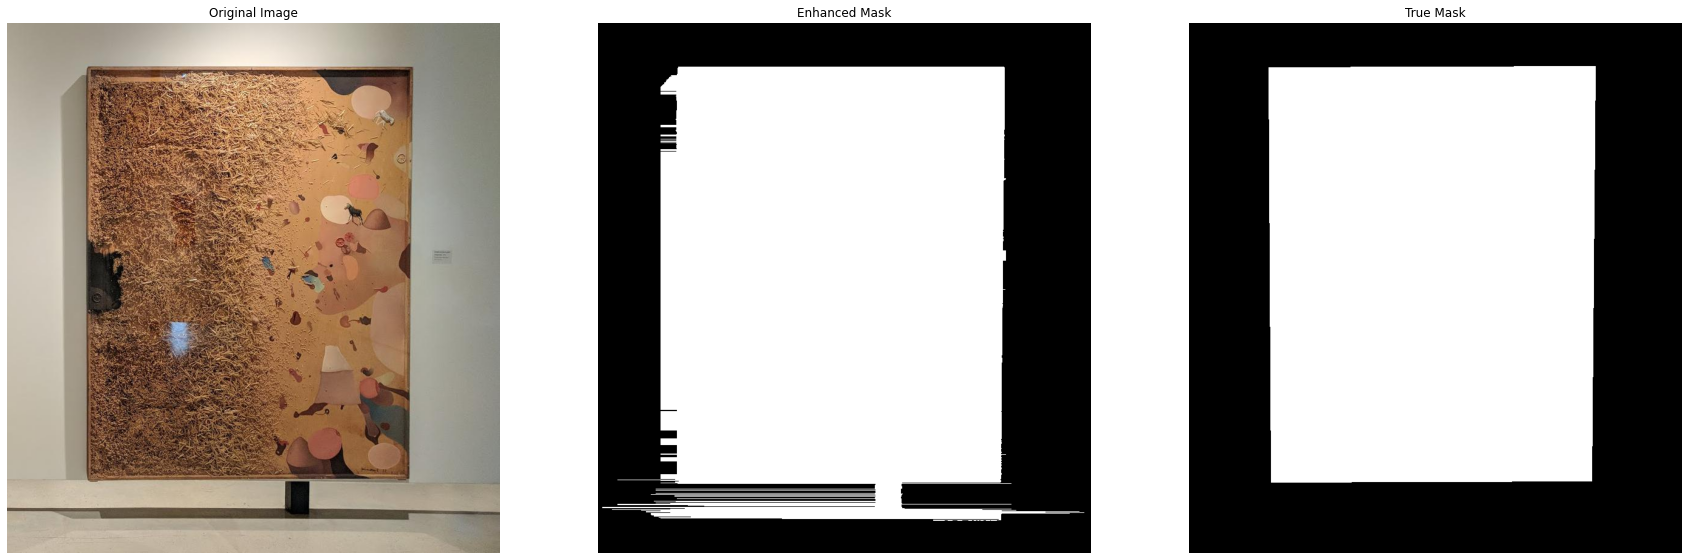

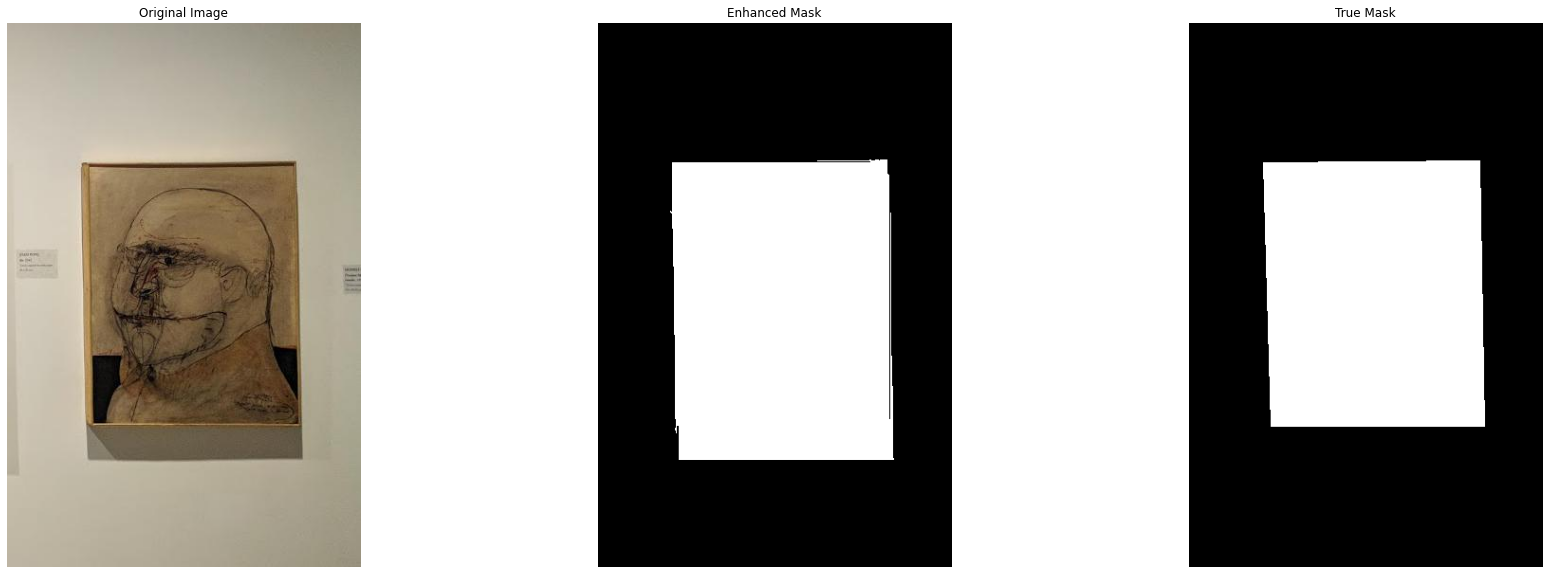

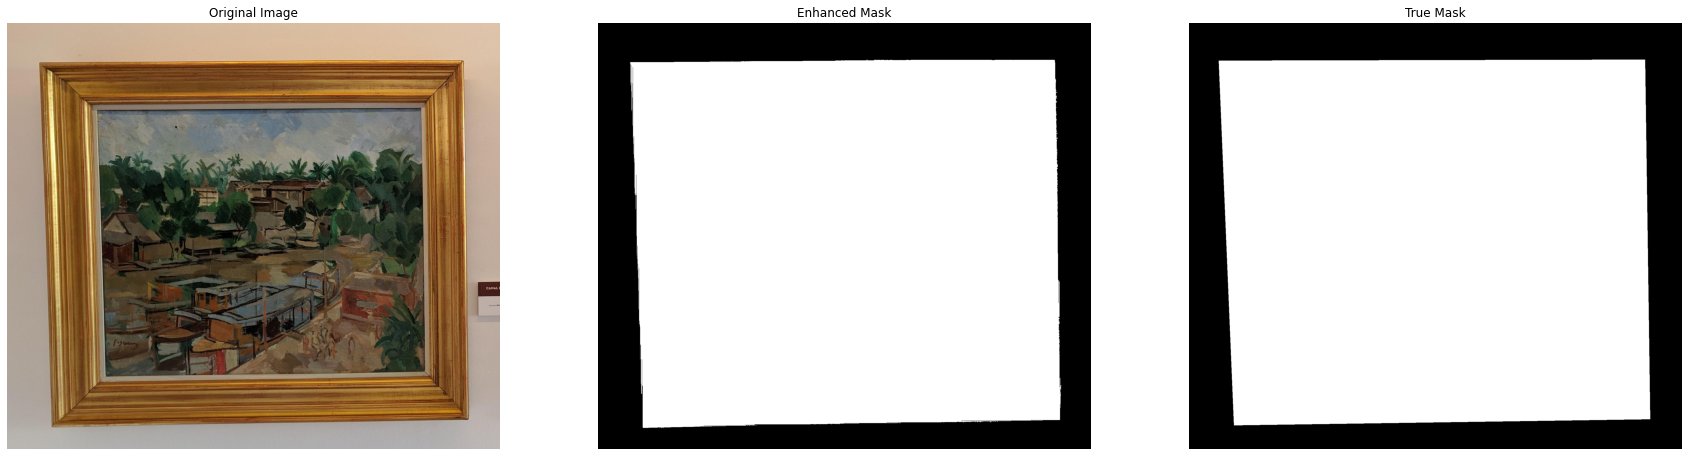

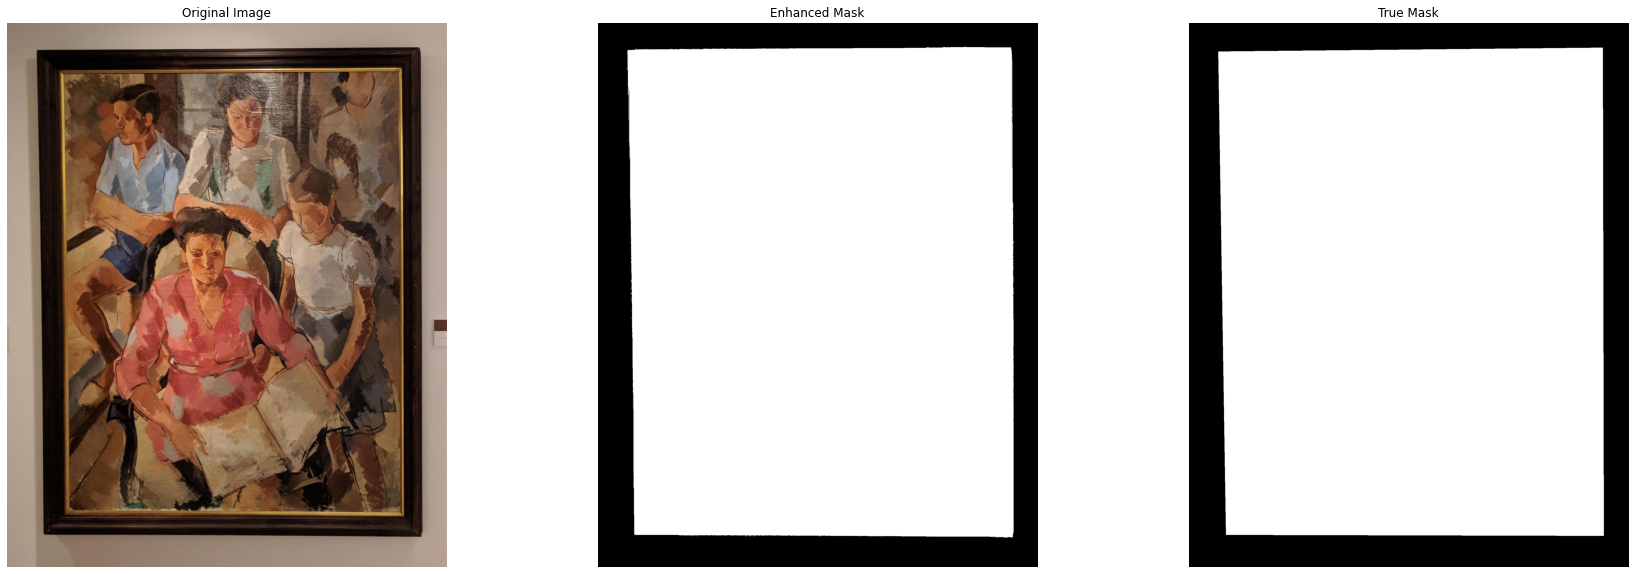

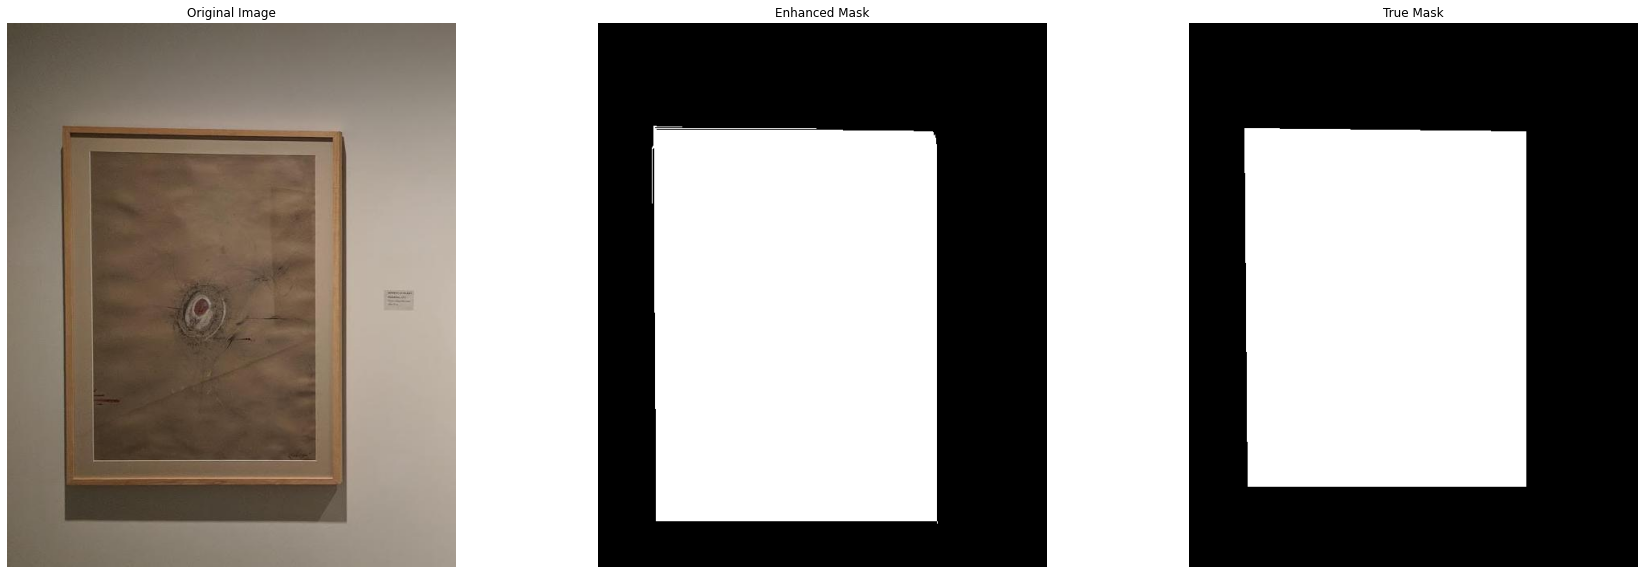

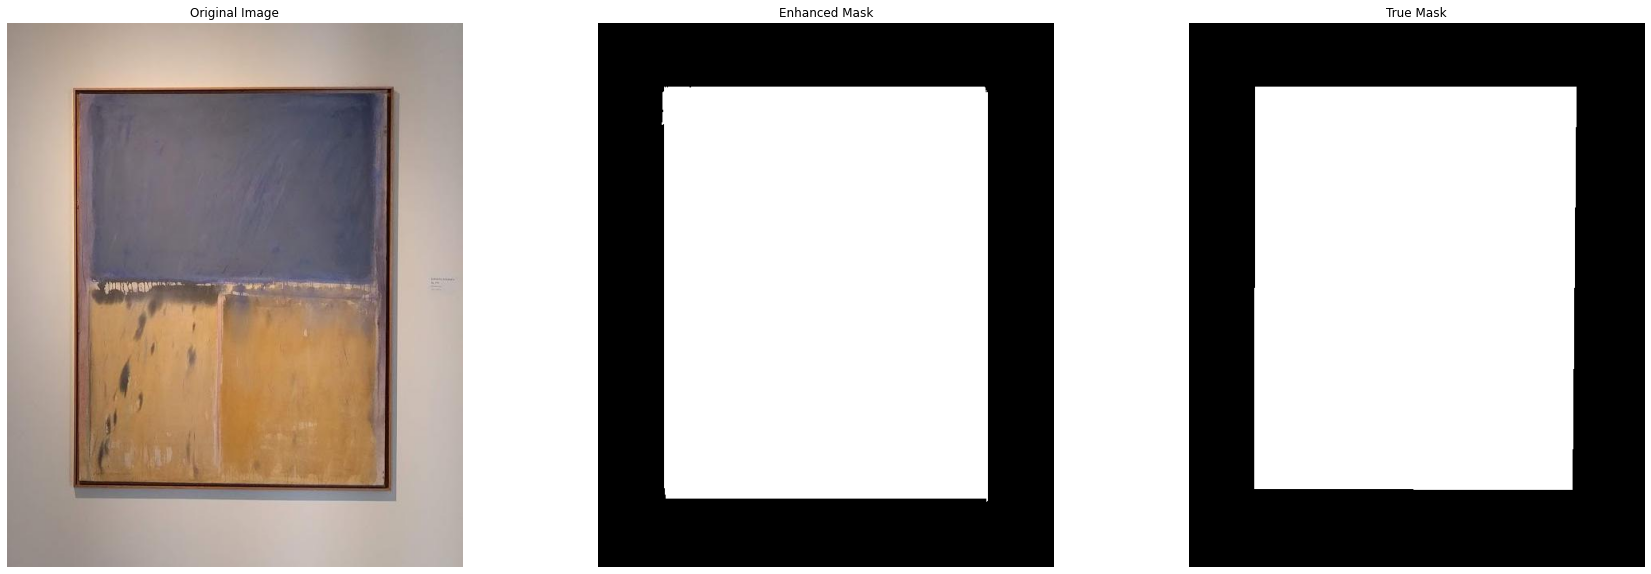

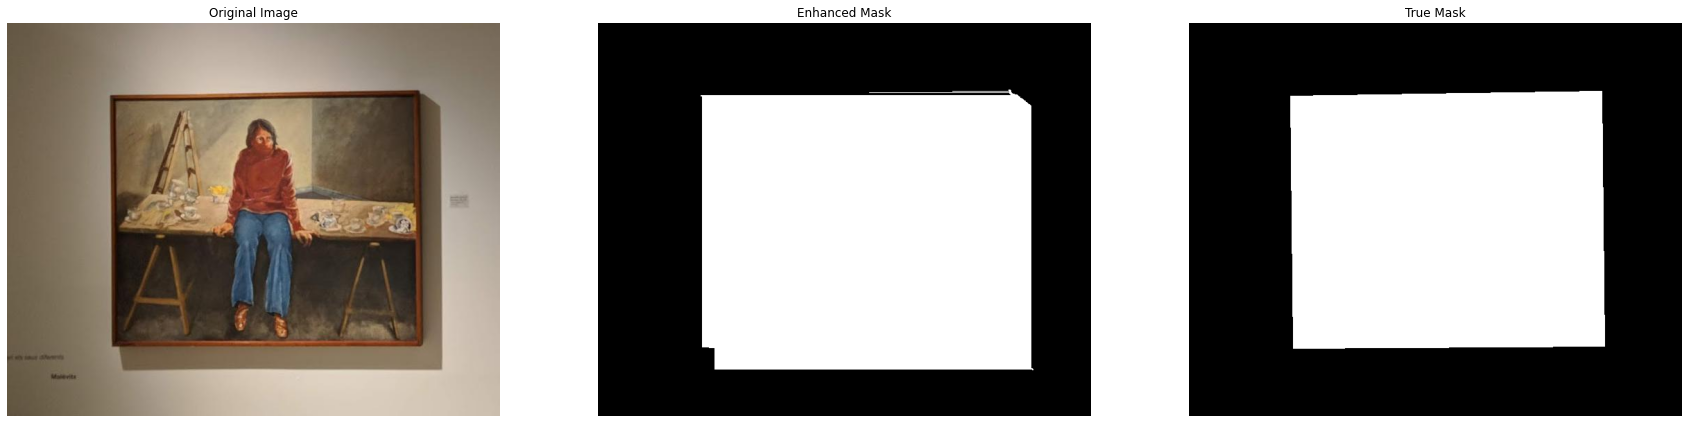

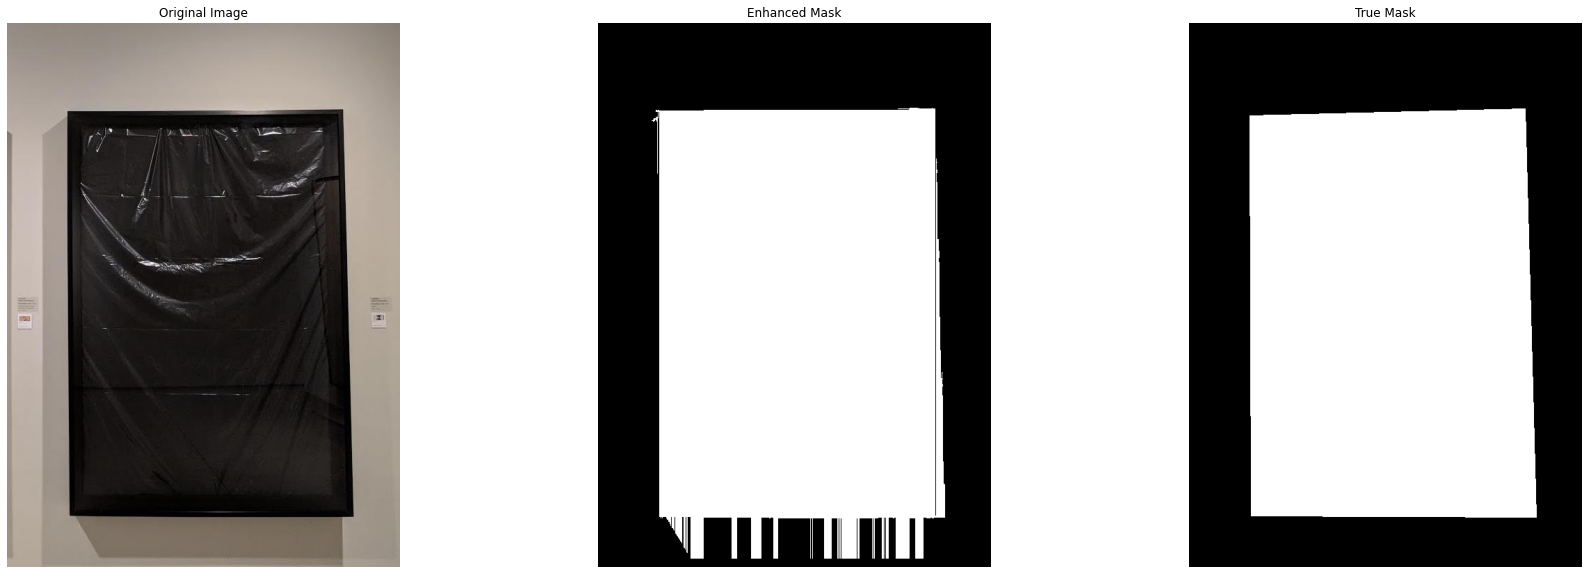

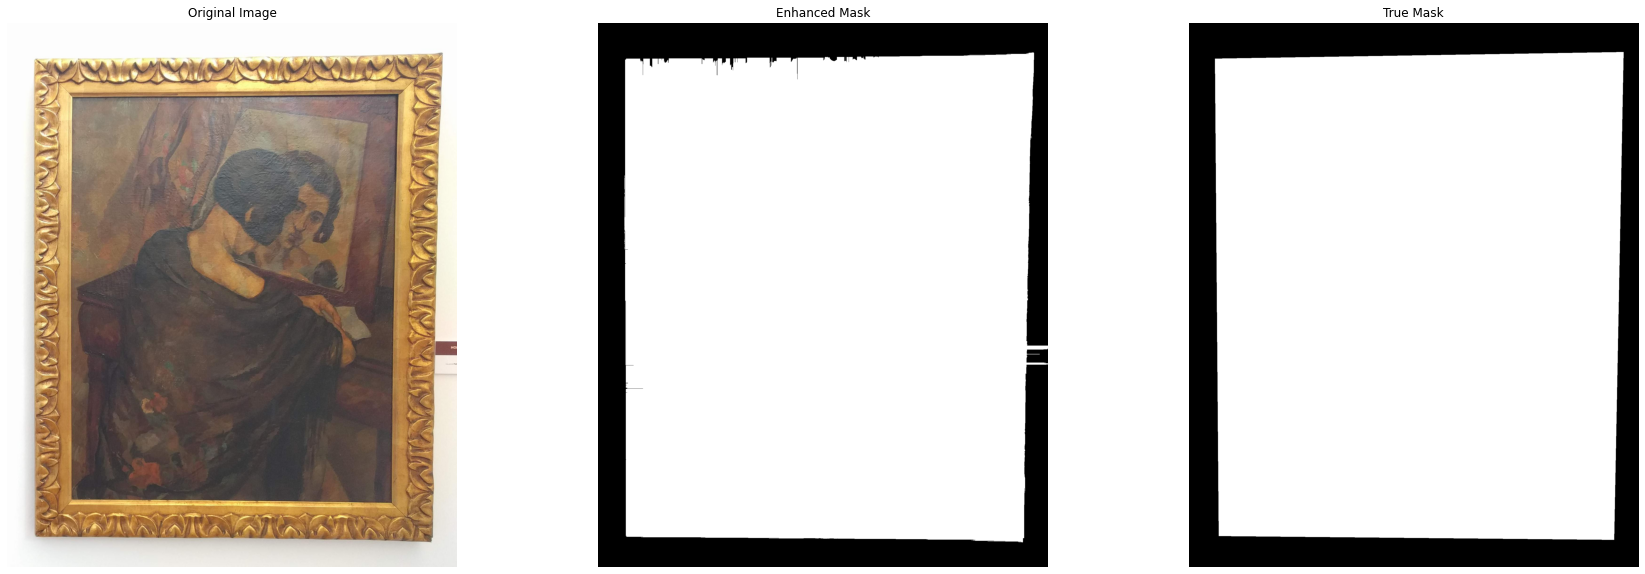

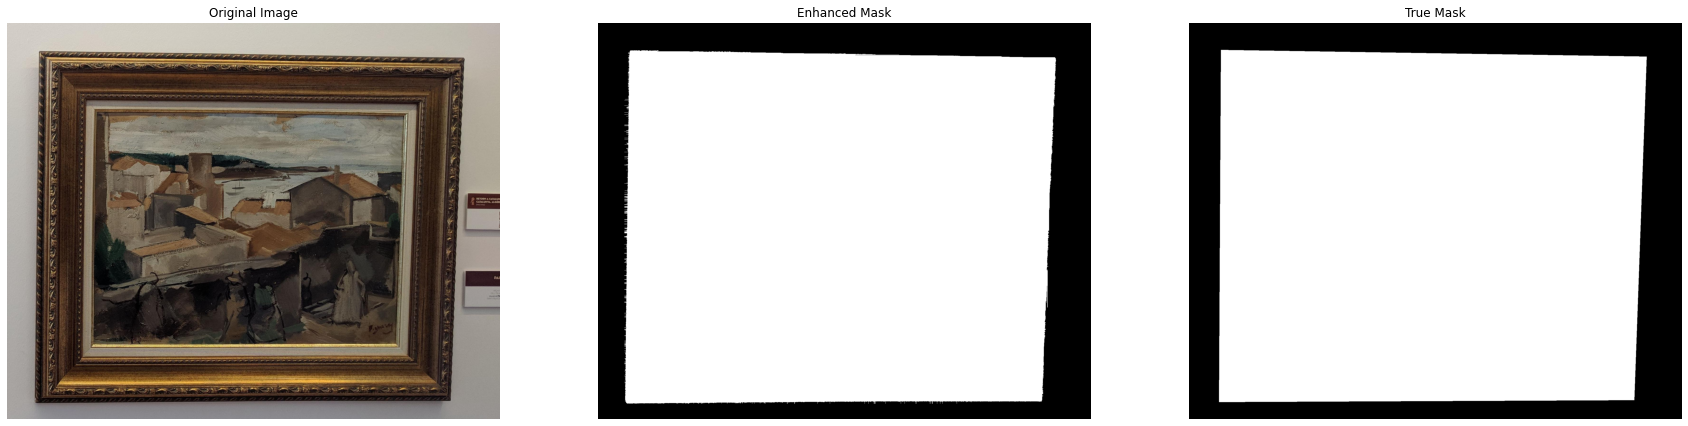

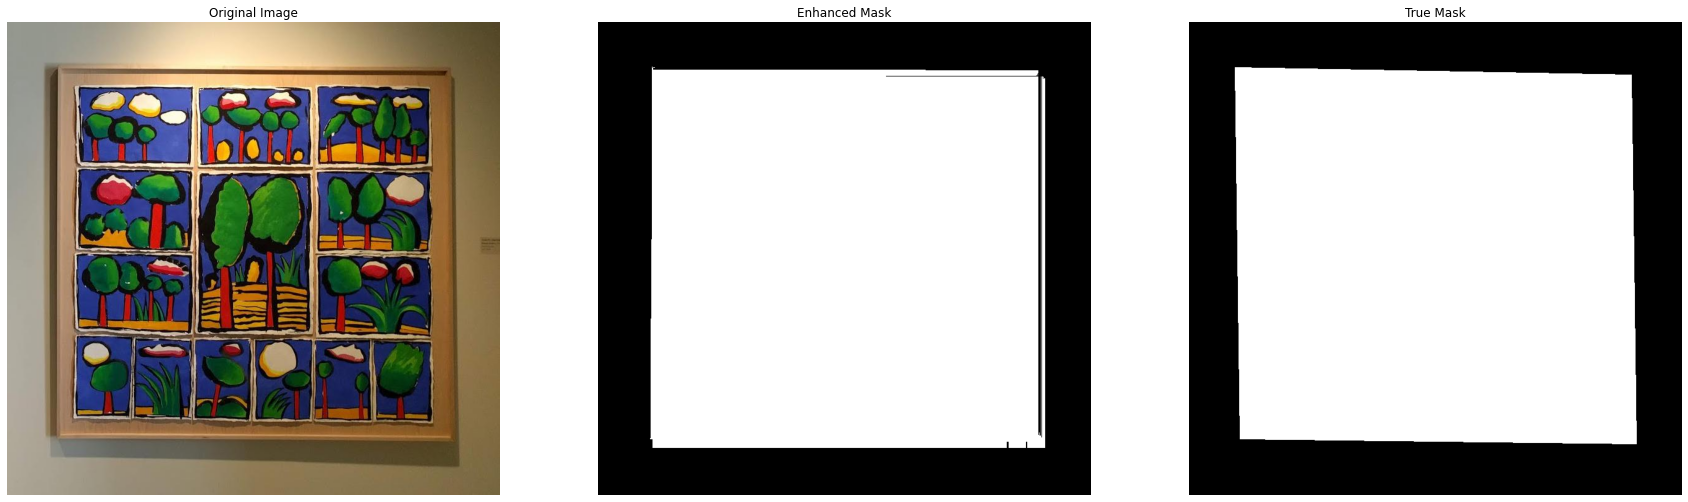

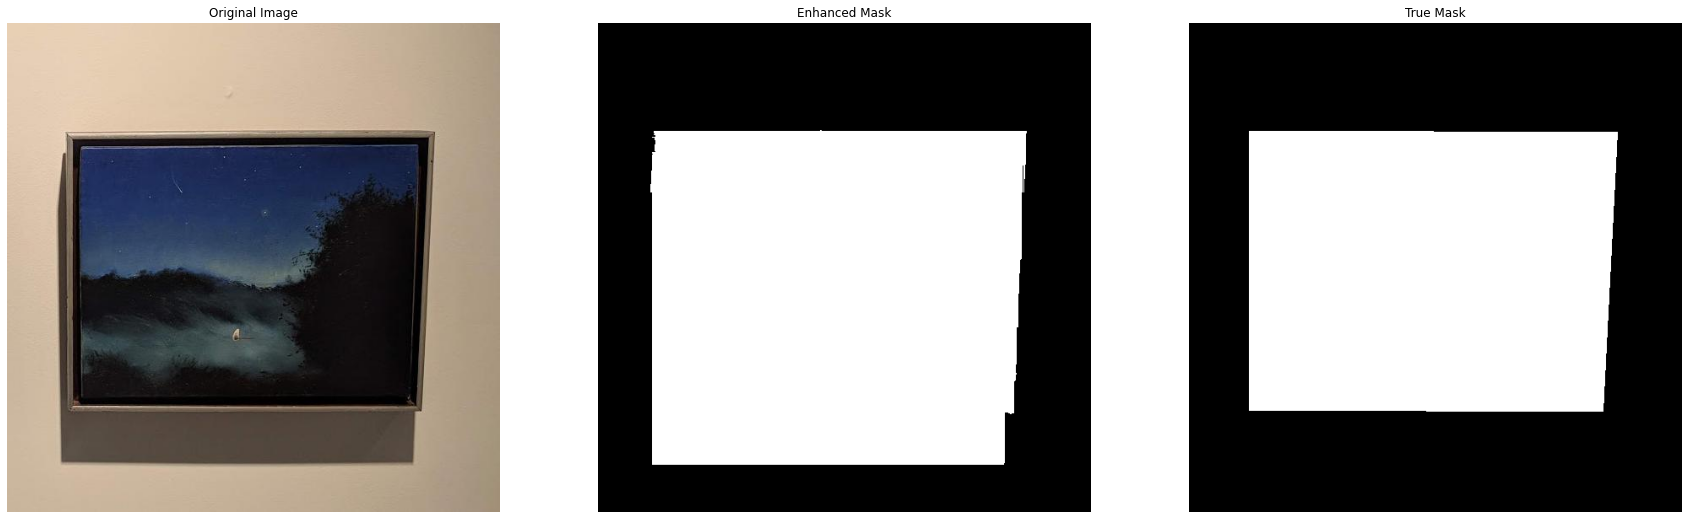

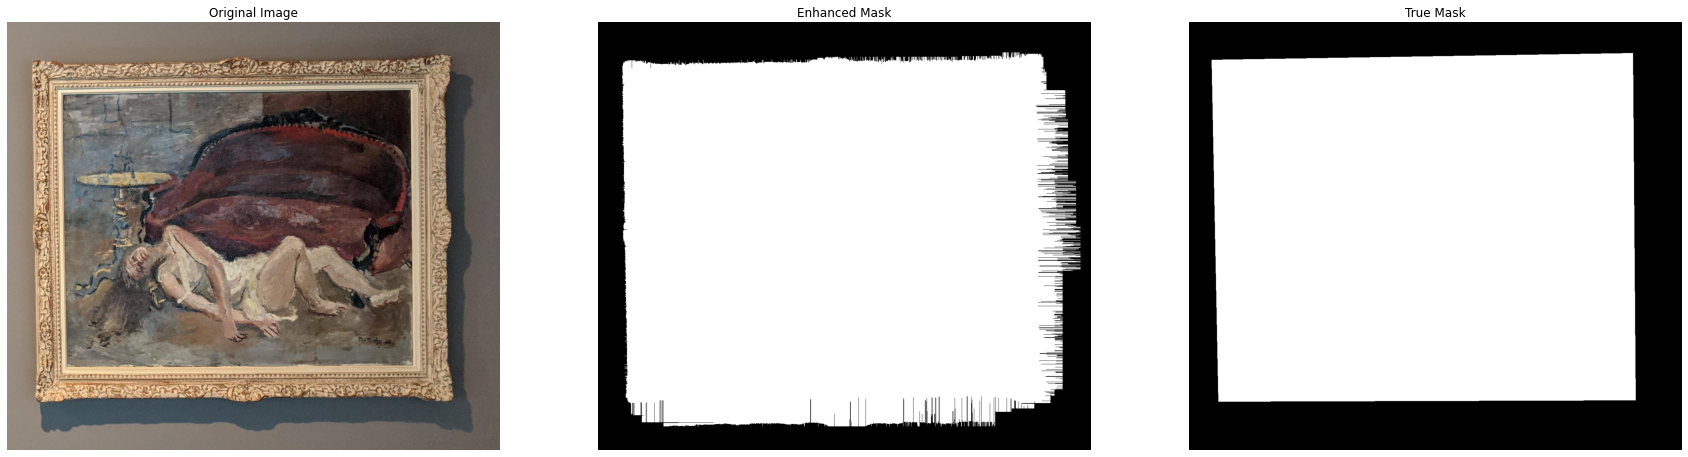

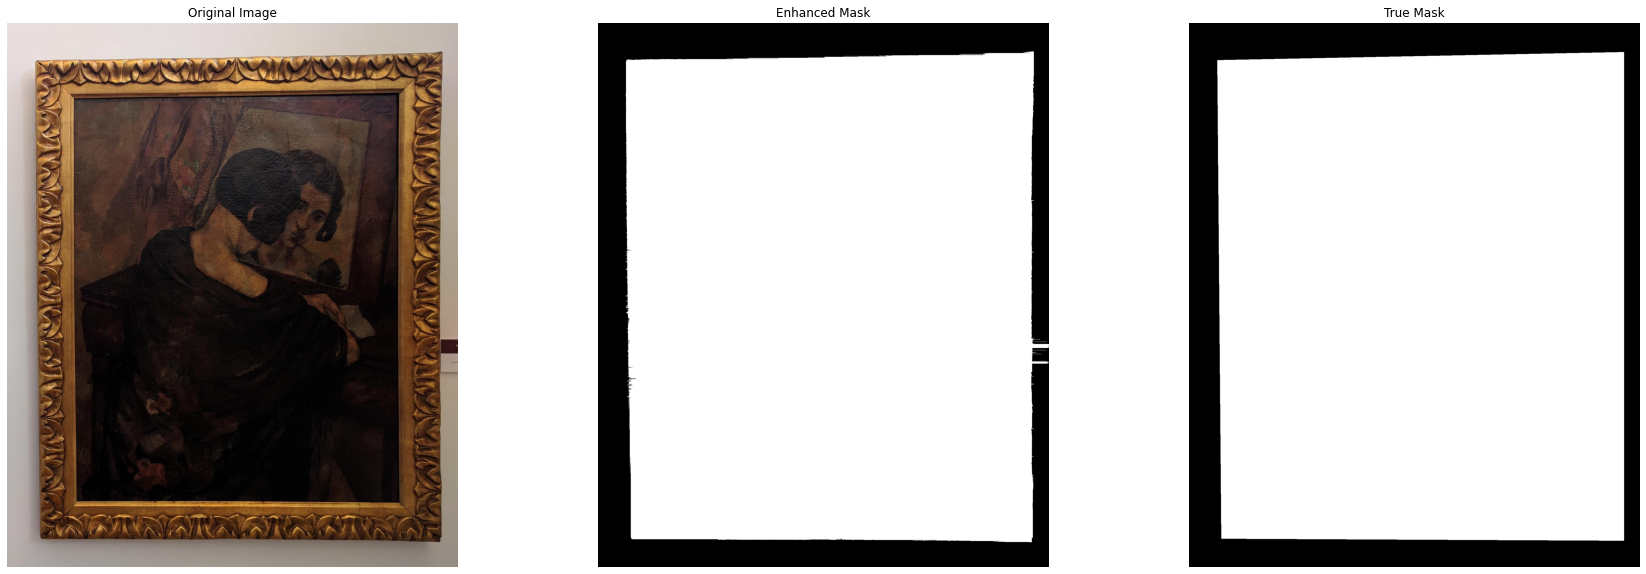

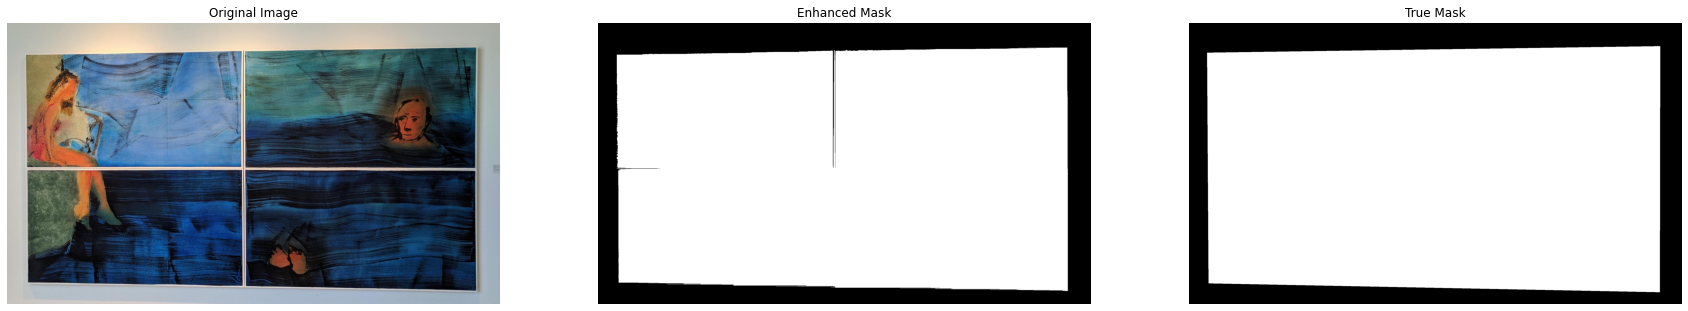

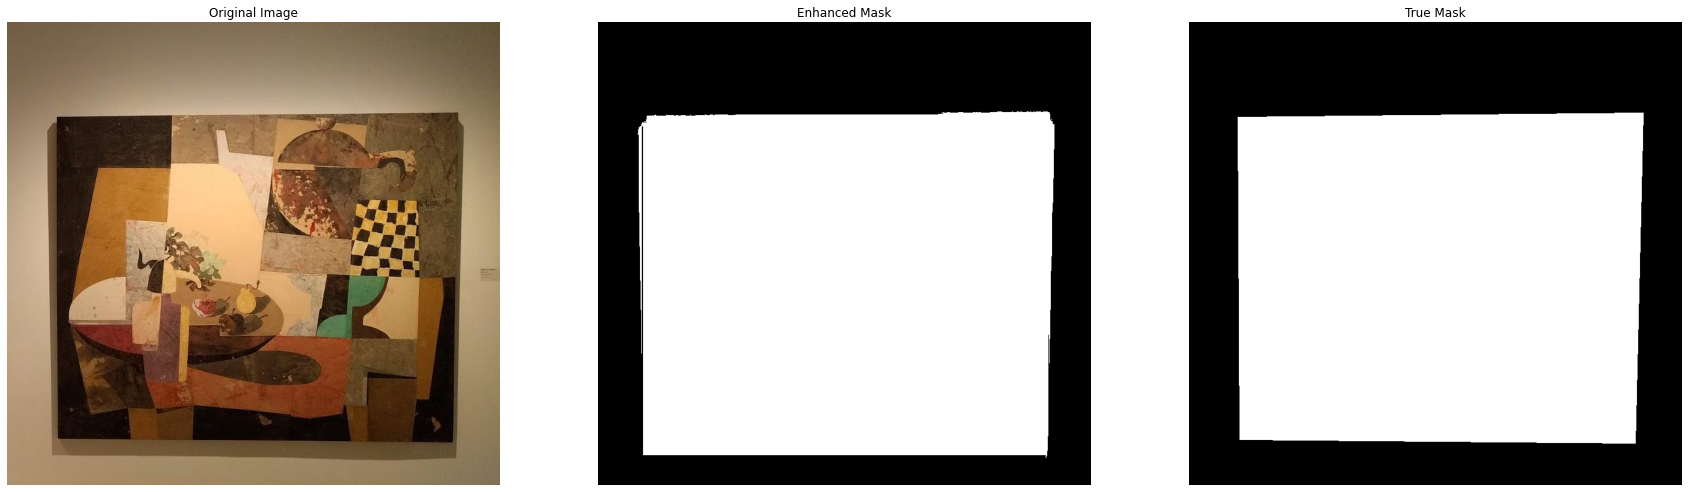

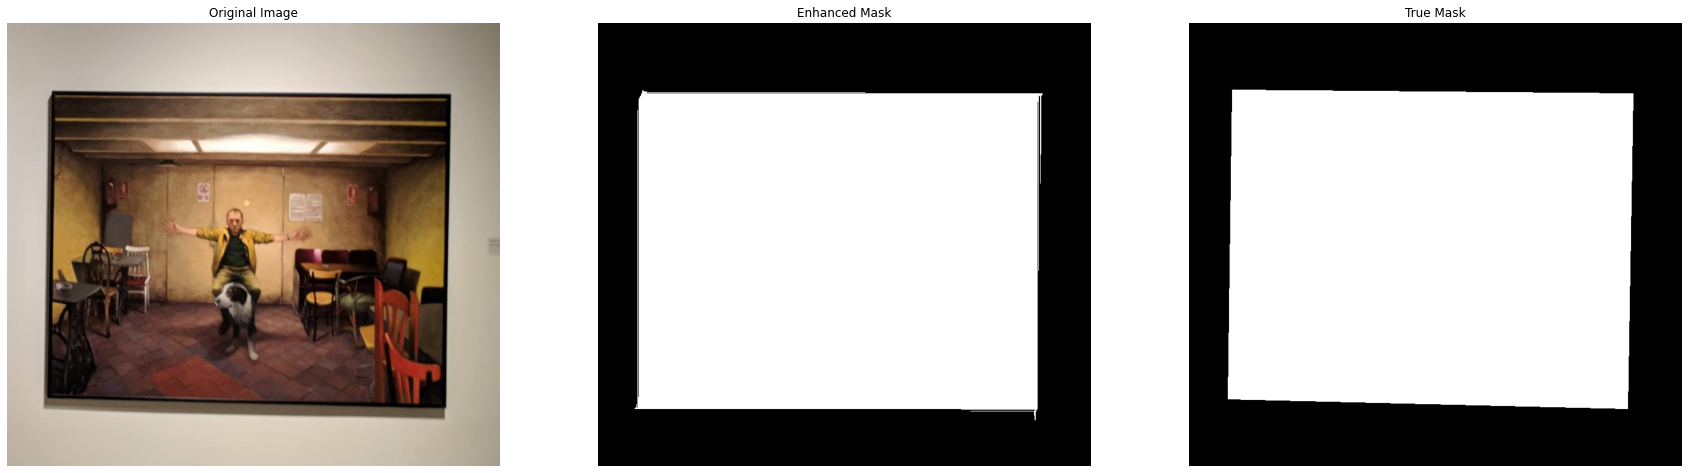

In [155]:
for idx, image in enumerate(query_set2_imgs[:20]):
    true_mask = query_set2_masks[idx]
    predicted_mask = background_removal(image)
    enhanced_mask = enhance_mask(predicted_mask)

    f, axs = plt.subplots(1,3, figsize=(30,10))
    axs[0].imshow(cv2.cvtColor(image, color_spaces["RGB"]))
    axs[0].title.set_text("Original Image")
    axs[1].imshow(enhanced_mask, cmap="gray")
    axs[1].title.set_text("Enhanced Mask")
    axs[2].imshow(true_mask, cmap="gray")
    axs[2].title.set_text("True Mask")

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')